In [1]:
from google.colab import files
uploaded = files.upload()

Saving Wholesale customers data.csv to Wholesale customers data.csv


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [3]:
wholesale = pd.read_csv('Wholesale customers data.csv')

In [4]:
wholesale.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:
wholesale.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


In [6]:
wholesale = wholesale[['Fresh',	'Milk',	'Grocery', 'Frozen', 'Detergents_Paper',	'Delicassen']]

In [7]:
wholesale.agg(['mean', 'std']).round(0)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
mean,12000.0,5796.0,7951.0,3072.0,2881.0,1525.0
std,12647.0,7380.0,9503.0,4855.0,4768.0,2820.0


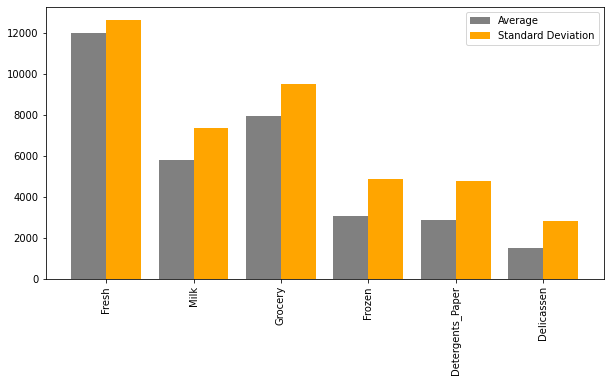

In [8]:
averages = wholesale.mean()
st_dev = wholesale.std()
x_names = wholesale.columns
x_ix = np.arange(wholesale.shape[1])

# plot the data
_ = plt.figure(figsize=(10, 5))
plt.bar(x_ix-0.2, averages, color='grey', label='Average', width=0.4)
plt.bar(x_ix+0.2, st_dev, color='orange', label='Standard Deviation', width=0.4)
plt.xticks(x_ix, x_names, rotation= 90)
plt.legend()
plt.show()

There is large differences in  both averages and standard deviation across variables.

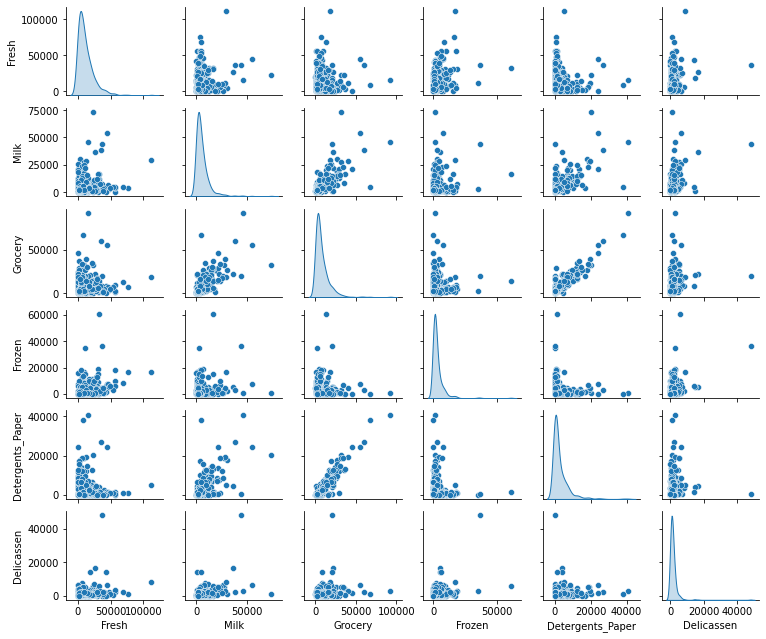

In [9]:
sns.pairplot(wholesale, diag_kind ='kde', height=1.5, aspect=1.2)
plt.show()

Estimated distributions on the diagonal are highly skewed which means that they are not normally distributed.(Pairs plot allow us to see both distribution of single variables and relationships between two variables)

# K-Means Clustering

K-Means clustering works well, when the data is normally distributed andstandardized.(mean = 0, std = 1)

### Unskewing data with log transformation

In [10]:
# taking the logarithm of our data
wholesale_log = np.log(wholesale)

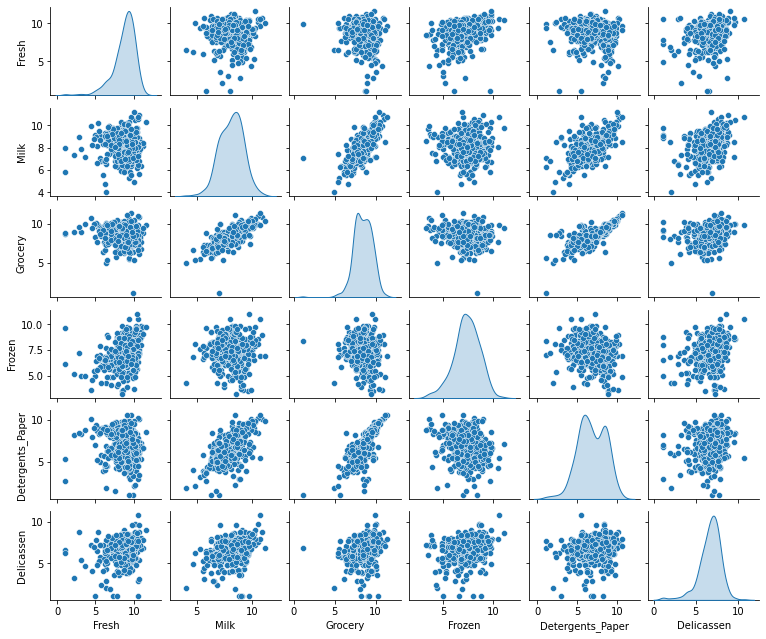

In [11]:
sns.pairplot(wholesale_log, diag_kind ='kde', height=1.5, aspect=1.2)
plt.show()

We see that the variables are less skewed and lool more bell-shaped, although the 'Fresh' variable still slightly skewed to the left.

### Unskewing data with Box-Cox transformation

In [12]:
from scipy import  stats

In [13]:
def boxcox_df(x):
  x_boxcox,  _ = stats.boxcox(x)
  return x_boxcox

wholesale_boxcox = wholesale.apply(boxcox_df, axis=0)

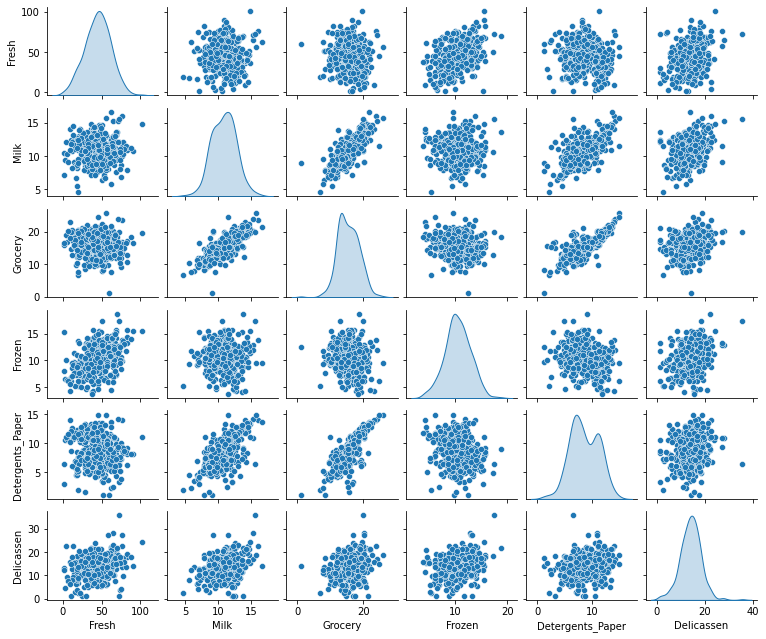

In [14]:
sns.pairplot(wholesale_boxcox, diag_kind ='kde', height=1.5, aspect=1.2)
plt.show()

All the variables seem to have normal distribution with this transformation.

### Scale the Data

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(wholesale_boxcox)
wholesale_scaled = scaler.transform(wholesale_boxcox)
wholesale_scaled_df = pd.DataFrame(data = wholesale_scaled, index= wholesale_boxcox.index, columns= wholesale_boxcox.columns )

In [16]:
wholesale_scaled_df.agg(['mean', 'std']).round()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
mean,-0.0,0.0,-0.0,-0.0,-0.0,0.0
std,1.0,1.0,1.0,1.0,1.0,1.0


### Segmentation with K-Means

In [17]:
from sklearn.cluster import KMeans
sse = {}
for k in range(1,11):
  kmeans = KMeans(n_clusters = k, random_state = 333)
  kmeans.fit(wholesale_scaled_df)
  sse[k] = kmeans.inertia_

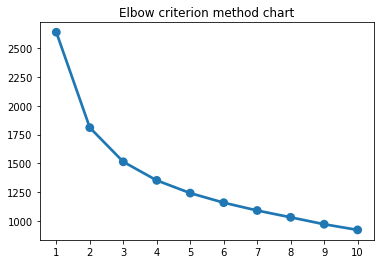

In [18]:
plt.title('Elbow criterion method chart')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

The optimal number of clusters mathematically are 3 or 4.

In [22]:
kmeans = KMeans(n_clusters = 4)
kmeans.fit(wholesale_scaled_df)
wholesale_kmeans4 = wholesale.assign(segment = kmeans.labels_)

Used assign method to create a new segment label column in the original unprocessed dataset. 

In [23]:
kmeans4_averages = wholesale_kmeans4.groupby(['segment']).mean().round()
print(kmeans4_averages)

           Fresh     Milk  Grocery  Frozen  Detergents_Paper  Delicassen
segment                                                                 
0        10012.0   1808.0   2299.0  2308.0             408.0       632.0
1        10229.0  12752.0  17996.0  1912.0            7767.0      2338.0
2        23304.0   4843.0   4953.0  7279.0             817.0      2877.0
3         3739.0   6346.0  10622.0   689.0            4398.0       575.0


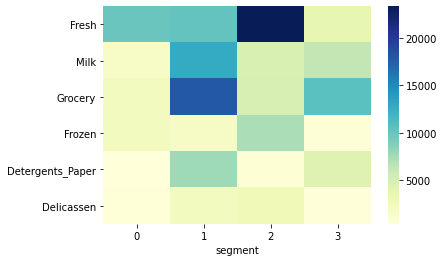

In [25]:
sns.heatmap(kmeans4_averages.T, cmap = 'YlGnBu')
plt.show()